The purpose of this notebook is to predict the survivors of the titanic given a sample of the data. The data and idea is taken from the competition Titanic: Machine Learning from Disaster on [Kaggle.com](https://www.kaggle.com/c/titanic)


Our method will focus on data processing before tackling the ML models

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
dataset = train_df.append(test_df, sort = False)

In [6]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Sort into discrete(catagorical) and continuous(numerical) data

Discrete is: Sex, Pclass, Cabin, Embarked, Parch, SibSp, Name, Ticket

Continuous is: PassengerId, Age, Fare

## Exploratory Data Analysis

#### discrete

##### Sex

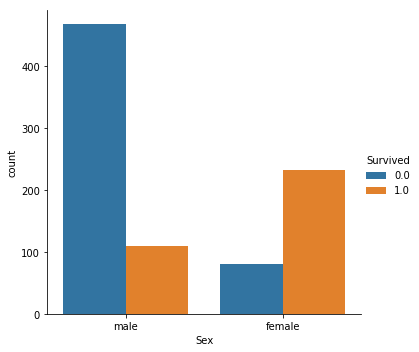

In [8]:
# Sex
# we know that this is the strongest indicator

sns.catplot(x = 'Sex', hue = 'Survived', data = dataset, kind = 'count')

In [9]:
# female survival rate
dataset.groupby('Sex').Survived.mean()
# encoding
dataset = pd.concat([dataset, pd.get_dummies(dataset.Sex)],axis = 1)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


Result is many more females survived despite most of the population being men.
An earlier model for prediction achieved reasonable results simply assuming all men died and all women survived

### Pclass

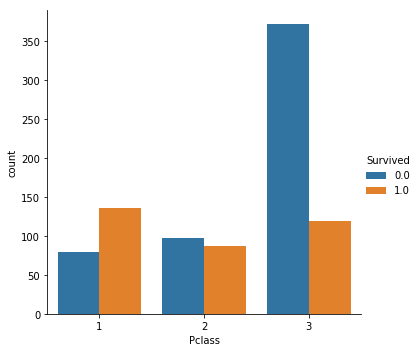

In [10]:
sns.catplot(x='Pclass',hue ='Survived',kind = 'count', data= dataset)

We can see that there is an increase in survival depending on pclass

first class had a good survival rate of over 50%, second class had slightly less and pclass 3 passengers had a very low survival rate

Pclass is naturally encoded

### Cabin

In [37]:
sum(dataset.Cabin.isna())/len(dataset.Cabin)*100

77.46371275783041

The Cabin column is missing a significant amount of data

The letters represent the deck and the numbers are the rooms

The missing data is denoted 'X'

The room numbers are not needed so the cabin letter in the beginning is extracted

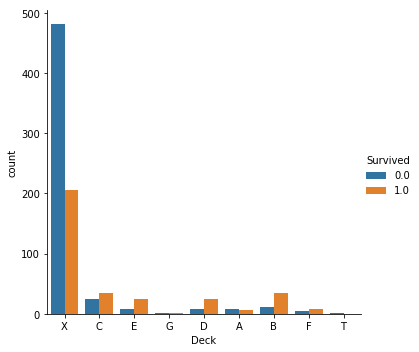

In [50]:
dataset.Cabin.fillna('X', inplace = True)
dataset['Deck'] = dataset.Cabin.str.extract(pat = '([a-zA-Z])')
# want plot of number of survivors vs non survivors for each deck
sns.catplot(x = 'Deck', hue = 'Survived', data = dataset, kind = 'count')

The fatality rate for missig deck is far greater than the others. <br>
This is likely due to the fact that the dead could not give out their cabin information afterwards

### Embarked

In [55]:
sum(dataset.Embarked.isna())
dataset.Embarked.fillna('X', inplace = True)

# only two points missin
# will replace them with 'X'

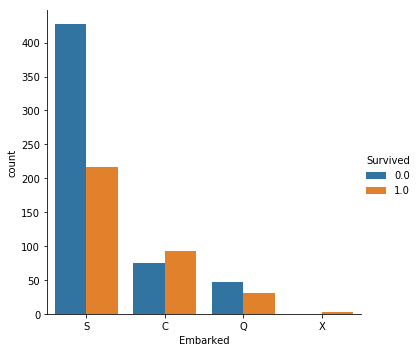

In [56]:
sns.catplot(x = 'Embarked', hue = 'Survived', data = dataset, kind = 'count')

In [35]:
pd.crosstab(dataset.Pclass, dataset.Embarked)
# chances of survival is better for those from point C and Q

Embarked,C,Q,S,X
Pclass,,,,
1,141,3,177,2
2,28,7,242,0
3,101,113,495,0


### SibSP and Parch

Various sources indicate that families tend to have a greater chance of survival

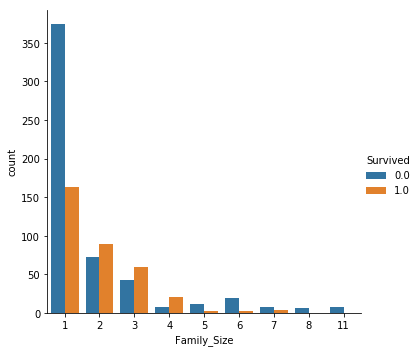

In [51]:
# we can get a count of the family size by adding up SibSp and Parch
dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1
# family size vs survival

sns.catplot(x = 'Family_Size', hue = 'Survived', data = dataset, kind = 'count')
# we can see that while the majority of people did not have family on board
# the ones with families tend to survive

In [61]:
dataset.groupby('Family_Size').Survived.mean()

Family_Size
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

### Name

In [16]:
dataset.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

### Ticket

What can we extract from the ticket?

All values in this column are string values. We need to extract all letters before hand

In [18]:
dataset[['Ticket','Name']].head()

,Ticket,Name
0,A/5 21171,"Braund, Mr. Owen Harris"
1,PC 17599,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,STON/O2. 3101282,"Heikkinen, Miss. Laina"
3,113803,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,373450,"Allen, Mr. William Henry"


In [64]:
f  = dataset.Ticket[dataset.Ticket == 'LINE']

In [67]:
## start with extracting the strings out
## removes the prefix
remove_pre = dataset.Ticket.str.extract(pat ='( [0-9].+)')
remove_pre;

#returns non prefix num
num_only = dataset.Ticket.str.extract(pat = '(\A[0-9].+)')
num_only;

# combine the two would allow for the complete ticket number without
# the prefixes
combined = dataset.Ticket.str.extract(pat = '(\A[0-9].+| [0-9].+)')
dataset['Tick_Num'] = combined
dataset['Tick_Num'].unique();


In [100]:
### lets try to find duplicate tickets
count = dataset.Ticket.groupby(dataset.Ticket).count()
# all the tickets with duplicates where index is tickets
dup = count[count>1]   

### make a loop which queries the ticket numbers from dup
def duplicate_ticket():
    new_list = []
    for i in range(len(dup)):
        temp = dataset[dataset.Ticket == dup.index[i]]
        new_list.append(temp)
    new_list = pd.concat(new_list)
    return new_list
    
len(duplicate_ticket())
dup_tick = duplicate_ticket()[['Name','Tick_Num','Fare','Cabin','Family_Size','Survived']].sort_values('Tick_Num')
dup_tick.head()

,Name,Tick_Num,Fare,Cabin,Family_Size,Survived
671,"Davidson, Mr. Thornton",12750,52.00,B71,2,0.0
92,"Davidson, Mrs. Thornton (Orian Hays)",12750,52.00,B71,4,NaN
211,"Cameron, Miss. Clear Annie",13528,21.00,X,1,1.0
349,"Walcroft, Miss. Nellie",13528,21.00,X,1,NaN
314,"Hart, Mr. Benjamin",13529,26.25,X,3,0.0


In [108]:
dataset.iterrows()

TypeError: 'generator' object is not subscriptable

In [114]:
row

In [120]:
## _ appears to be the ticket
## df_grp is the group of passengers which shares
## ticket, Fare and family size attributes


dataset['Connected_Survival'] =  train_df.Survived.mean()# default 
for _, df_grp in dataset.groupby('Ticket'):
    if (len(df_grp) > 1): ## means there is a duplicate ticket if >12
        # so if passenger has a duplicate ticket with someone else 
        for ind, row in df_grp.iterrows():
            # loops through index and rows of each "group"
            # 
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(dup_tick))
print("people have connected information : %.0f" 
      %(dataset[dataset['Connected_Survival']!=0.5].shape[0]))
dataset.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 1309


,Survived
Connected_Survival,
0.000000,0.225
0.383838,0.298
1.000000,0.728


This is all the passengers with at least one duplicate ticket 596

Ticket number and Fare tend to pair up. If Ticket number is the same, then the Fare is likely the same


We can use some of the columns to create a value which accounts for family/grouplike characteristics. They are:

Ticket(duplicates), Fare, Survived, and Family Size

We will call this column Group_Survival

If Fare, ticket_number and family size match another person, then we can assume that the person (group) survived

If the group like characteristics are true then we can say that group_survival is 1. Otherwise it is zero. If no data then we can say it is the average

In [92]:
dup_tick = pd.unique(duplicate_ticket().Ticket)

array(['110152', '110413', '110465', '110813', '111361', '112058',
       '112378', '113059', '113503', '113505', '113509', '113572',
       '113760', '113773', '113776', '113781', '113789', '113796',
       '113798', '113803', '113806', '11668', '11751', '11753', '11765',
       '11767', '11769', '11778', '11813', '11967', '12749', '13050',
       '13236', '13502', '13507', '13508', '13567', '13695', '1601',
       '16966', '17421', '17453', '17463', '17464', '17474', '19877',
       '19928', '19943', '19950', '19996', '2003', '21228', '220845',
       '226875', '228414', '230080', '230136', '230433', '231919',
       '236853', '237736', '237789', '239853', '239865', '24065', '24160',
       '243847', '244252', '244358', '244367', '248727', '248738',
       '250644', '250647', '250649', '250651', '250655', '2625', '2627',
       '26360', '2650', '2651', '2653', '2659', '2660', '2661', '2662',
       '2665', '2666', '2668', '26707', '2678', '2680', '2689', '2691',
       '2699', '28220

In [118]:
dataset.groupby('Ticket')

In [81]:
# set default as the average survival rate

dataset['Group_Survival'] =  train_df.Survived.mean()

# if the Fare, dup_tick and famil


In [80]:
dup_tick.groupby('Tick_Num').Survived.mean()

Tick_Num
 12750    0.000000
 13528    1.000000
 13529    0.666667
 13534         NaN
 14879    0.000000
 17477    1.000000
 17483    0.000000
 17485    1.000000
 17558    0.500000
 17569    1.000000
 17572    1.000000
 17582    0.666667
 17585    1.000000
 17592    1.000000
 17593    0.000000
 17597    0.000000
 17599    1.000000
 17603    1.000000
 17604    0.500000
 17608    1.000000
 17611    1.000000
 17755    1.000000
 17756    1.000000
 17757    0.750000
 17758    0.500000
 17759    1.000000
 17760    0.666667
 17761    0.500000
 2079     0.500000
 2123     0.666667
            ...   
349910    0.000000
350026    0.000000
350405         NaN
35273     0.666667
35281     0.000000
358585    0.000000
363291    0.666667
364498    0.000000
364516    1.000000
364849    0.000000
36568     0.000000
367226    1.000000
367230    1.000000
36928     1.000000
36947     1.000000
36973     0.500000
370129    0.000000
370365    0.500000
370371    0.000000
371110    0.333333
371362    0.000000
376

Family Survival

## Continuous Data

#### Fare

In [25]:
# fill in the missing value
# only one so we can just use median
sum(dataset.Fare.isna())
dataset.Fare.fillna(dataset.Fare.median(), inplace = True)

In [26]:
### lets split the fare into groups
dataset['qfare'] = pd.qcut(dataset.Fare,5, duplicates = 'drop')

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
dataset['Enfare'] = label.fit_transform(dataset.qfare)

## want to see the survival rate of each qcuts
pd.crosstab(dataset.Enfare, dataset.Survived)
# interestingly the ones that paid the most had a higher chance 
# of survival. This may be due to the more expansive cabins were likely
# located on the highest deck.
# This would make sense since the survival rate of the lower decks is very
# low

Survived,0.0,1.0
Enfare,,
0,140,39
1,147,37
2,98,73
3,103,82
4,61,111


In [27]:
pd.crosstab(dataset.Enfare, dataset.Pclass)
# further analysis shows this to be likely as well since the highest
# priced cabins were mostly for pclass 1 

Pclass,1,2,3
Enfare,,,
0,8,6,261
1,0,36,218
2,0,124,132
3,95,99,71
4,220,12,27


### Age

In [28]:
sum(dataset.Age.isna())
dataset.Age.fillna(dataset.Age.median(), inplace = True)

In [29]:
### want to split into groups (quantiles) like Fare
### and then encode them 
### we use label encoding here since there is an actual order to age

dataset['qAge'] = pd.qcut(dataset.Age,9, duplicates = 'drop')
label2 = LabelEncoder()
dataset['EnAge'] = label2.fit_transform(dataset.qAge)
## survival relative to age
pd.crosstab(dataset.EnAge, dataset.Survived)

Survived,0.0,1.0
EnAge,,
0,52,61
1,81,37
2,44,26
3,162,76
4,31,18
5,56,52
6,71,35
7,52,37


Many of the younger people did not make it

In [30]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'female', 'male',
       'Family_Size', 'Tick_Num', 'qfare', 'Enfare', 'qAge', 'EnAge'],
      dtype='object')

## Fine parameter tuning

### Machine Learning Model

In [122]:
train_df2.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'female', 'male',
       'Family_Size', 'Tick_Num', 'qfare', 'Enfare', 'qAge', 'EnAge', 'Deck',
       'Group_Survival', 'Connected_Survival'],
      dtype='object')

In [131]:
#We will use a random forest model
train_df2 = dataset[:len(train_df)]
test_df2 = dataset[len(train_df):]

columns = ['Pclass', 'Connected_Survival', 'Enfare','male','female']
# training data and predictor
X = train_df2[columns]
y = train_df2['Survived']

# testing data
X2 = test_df2[columns]

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=30,oob_score=True)
rf_model.fit(X,y)

prediction = rf_model.predict(X2)

In [132]:
rf_model.oob_score_

0.8170594837261503

In [135]:
X_Submit = test_df2.drop(labels=['PassengerId'],axis=1)

prediction = rf_model.predict(X2)

submit = pd.DataFrame({"PassengerId": test_df2['PassengerId'],
                      "Survived":prediction.astype(int)})
submit.to_csv("my_submission.csv",index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


On the ladder board this scores a 0.80382